In [307]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import os
from dotenv import load_dotenv
import requests
from pathlib import Path

from polygon import RESTClient

import matplotlib.pyplot as plt
import seaborn as sns

import fastcore.all as fc

In [157]:
# FOR THIS WE WILL USE THE POLYGON API
load_dotenv()
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

# load our polygon client
polygon_client = RESTClient(api_key=POLYGON_API_KEY)

In [516]:
# lets grab bar data for nvidia for the last 2 years
# List Aggregates (Bars)
ticker = "TLSA"
bars = polygon_client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_="2021-01-09", to="2023-01-10")

In [517]:
bars[0]

Agg(open=3.05, high=3.25, low=3.02, close=3.13, volume=315930, vwap=3.1255, timestamp=1614142800000, transactions=1295, otc=None)

In [568]:
def to_dict(bar):
    return {"timestamp":bar.timestamp, "open": bar.open, "high": bar.high, "low": bar.low, "close": bar.close, "volume": bar.volume, "vwap": bar.vwap, "transactions": bar.transactions}

In [569]:
# convert to a list of dicts
dict_bars = [to_dict(bar) for bar in bars]

In [570]:
# convert to a dataframe
df = pd.DataFrame(dict_bars)

In [571]:
# let's calculate the change in price from day to day
df['change'] = df['close'].pct_change()

In [572]:
df.describe()

,timestamp,open,high,low,close,volume,vwap,transactions,change
count,4.740000e+02,474.000000,474.000000,474.000000,474.000000,4.740000e+02,474.000000,474.000000,473.000000
mean,1.643598e+12,1.348544,1.400587,1.292586,1.344544,2.383408e+05,1.346201,764.860759,-0.002043
std,1.712125e+10,0.747593,0.768883,0.719970,0.739582,8.301077e+05,0.745417,2220.353189,0.053406
min,1.614143e+12,0.540000,0.575000,0.528700,0.550000,3.358000e+03,0.555300,37.000000,-0.337270
25%,1.628762e+12,0.746400,0.780000,0.712450,0.750250,5.505875e+04,0.748600,169.250000,-0.032419
50%,1.643648e+12,0.989950,1.040000,0.941300,0.985000,9.950700e+04,0.984700,371.000000,-0.002747
75%,1.658441e+12,1.865000,1.967500,1.822525,1.900000,2.051890e+05,1.904225,768.500000,0.025424
max,1.673327e+12,3.250000,3.350000,3.150000,3.240000,1.412027e+07,3.255100,40092.000000,0.304176


In [573]:
# set the timestamp to real datetime, as month, day, year
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [599]:
def zscore_normalize(data):
    """Apply z-score normalization to a column of data"""
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

# minmax normalize function
def minmax_normalize(data):
    """Apply minmax normalization to a column of data"""
    minimum = np.min(data)
    maximum = np.max(data)
    normalized_data = (data - minimum) / (maximum - minimum)
    return normalized_data

In [600]:
def normalize_(normalization_fn, df, columns=['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions']):
    """Apply a normalization function to a dataframe"""
    for column in columns: df[column] = normalization_fn(df[column])

In [601]:
# let's normalize the data
normalize_(zscore_normalize, df)

In [602]:
df.describe()

,open,high,low,close,volume,vwap,transactions,change
count,4.740000e+02,4.740000e+02,4.740000e+02,4.740000e+02,4.740000e+02,4.740000e+02,474.000000,473.000000
mean,-2.398456e-16,5.996141e-17,2.398456e-16,5.996141e-17,-2.998071e-17,-5.996141e-17,0.000000,-0.002043
std,1.001057e+00,1.001057e+00,1.001057e+00,1.001057e+00,1.001057e+00,1.001057e+00,1.001057,0.053406
min,-1.082672e+00,-1.074882e+00,-1.062118e+00,-1.075451e+00,-2.833742e-01,-1.062139e+00,-0.328159,-0.337270
25%,-8.062943e-01,-8.079802e-01,-8.066295e-01,-8.044035e-01,-2.210264e-01,-8.025471e-01,-0.268534,-0.032419
50%,-4.801714e-01,-4.694701e-01,-4.884333e-01,-4.866590e-01,-1.674247e-01,-4.854771e-01,-0.177574,-0.002747
75%,6.915548e-01,7.380994e-01,7.368340e-01,7.518338e-01,-3.997895e-02,7.493971e-01,0.001641,0.025424
max,2.546124e+00,2.538062e+00,2.582573e+00,2.565583e+00,1.674072e+01,2.563552e+00,17.730823,0.304176


In [603]:
# let's create a dataset with 4 week windows
def create_window(df, n=0, window_size=28, columns=['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions']):
    window_data = df.iloc[n:window_size+n]
    return {"data": window_data[columns].values, "target": window_data["change"].values[-1], "timestamp": window_data["timestamp"].values[-1]}

In [604]:
# create windows sliding with stride of 1
windows = [create_window(df, n=n) for n in range(len(df)-28)]
len(windows)

446

In [605]:
# let's split our windows to train and test
train_windows = windows[:int(len(windows)*0.8)]
test_windows = windows[int(len(windows)*0.8):]

In [606]:
# function to create a spectrogram
def create_spectrogram(window):
    # create a spectrogram
    spectrogram = np.abs(np.fft.fft(window, axis=0))
    # take the top half of the spectrogram
    spectrogram = spectrogram[:spectrogram.shape[0]//2]
    return spectrogram

In [607]:
class TabularStockDataset(Dataset):
    def __init__(self, windows):
        self.X = [window["data"] for window in windows]
        self.y = [window["target"] for window in windows]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

In [582]:
# lets create a dataset class
class CNNStockDataset(Dataset):
    def __init__(self, windows): 
        # convert to spectrogram
        self.X = [create_spectrogram(window["data"]) for window in windows]
        self.y = [window["target"] for window in windows]
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)

In [608]:
from dataclasses import dataclass

In [609]:
@dataclass
class Dls:
    train: DataLoader
    valid: DataLoader

In [610]:
# # create our datasets
# dls = Dls(
#     train=DataLoader(CNNStockDataset(train_windows), batch_size=32, shuffle=True),
#     valid=DataLoader(CNNStockDataset(test_windows), batch_size=32, shuffle=True)
# )
# create our datasets
dls = Dls(
    train=DataLoader(TabularStockDataset(train_windows), batch_size=32, shuffle=True),
    valid=DataLoader(TabularStockDataset(test_windows), batch_size=32, shuffle=True)
)

In [611]:
xb, yb = next(iter(dls.train))

In [612]:
xb.shape, yb.shape

(torch.Size([32, 28, 7]), torch.Size([32]))

In [613]:
def baselayer(ni, nf, batch_norm=True, bn_first=False, act_fn=nn.ReLU):
    layers = [nn.Linear(ni, nf, bias=not batch_norm)]
    if batch_norm and bn_first: layers.append(nn.BatchNorm1d(nf))
    if act_fn is not None: layers.append(act_fn())
    if batch_norm and not bn_first: layers.append(nn.BatchNorm1d(nf))
    return layers

In [ ]:
class SimpleTabularNet:
    def __init__(self, nfs, batch_norm=True, bn_first=False, act_fn=nn.ReLU):
        self.layers = []
        for ni, nf in zip(nfs[:-1], nfs[1:]):
            self.layers += baselayer(ni, nf, batch_norm, bn_first, act_fn = False if nf == nfs[-1] else act_fn)
        self.layers = nn.Sequential(*self.layers)

In [588]:
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(data, device=def_device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [589]:
class Learner:
    """This is our main class that will be responsible to experimenting and training various models. It serves the purpose of being a vehicle to experiment quickly"""
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        """
        model: <PyTorch Model> the model we are going to train
        dls: <Pytorch DataLoader> the dataloaders we are going to use
        loss_func: <Callable> the loss function we are going to use
        lr: <float> the learning rate we are going to use
        opt_func: <PyTorch optimizer (can be custom)> the optimizer we are going to use
        """
        fc.store_attr() # easy method to store all attributes, prevents mistakes

    def one_batch(self):
        """This method is responsible for one batch of training/evaluation"""
        self.xb, self.yb = to_device(self.batch) # move batch to device
        self.preds = self.model(self.xb) # get predictions
        self.loss = self.loss_func(self.preds, self.yb) # calculate loss
        if self.model.training:
            self.loss.backward() # calculate gradients
            self.opt.step() # update weights
            self.opt.zero_grad() # zero gradients
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        """This method is responsible for calculating statistics"""
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train # set model to training mode or evaluation mode
        dl = self.dls.train if train else self.dls.valid # get the correct dataloader
        for self.num, self.batch in enumerate(dl): 
            self.one_batch() # call one_batch method, self.batch will be set to the current batch
        n = sum(self.ns)
        print(f"Epoch: {self.epoch+1}", 'train' if self.model.training else 'valid', f"Loss: {sum(self.losses).item()/n}")
    
    def fit(self, n_epochs):
        """Very lightweight fit method, this is the highest level to train a model via the Learner object"""
        self.losses, self.ns = [], []
        self.model.to(def_device) # place model on appropriate device TODO: Allow this to be changed via fit calls if necessary
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr) # create optimizer
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # training
            self.one_epoch(False) # evaluation

In [593]:
#export
# Creating conv function to return a customized conv layer
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

# Let's now create a simple cnn
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 1, act=False),
    nn.Flatten() # flatten our conv output to feed into a linear layer
)

In [594]:
learn = Learner(simple_cnn, dls, nn.MSELoss(), lr=0.01)

In [595]:
learn.fit(10)

Epoch: 1 train Loss: 0.0034969325145978608
Epoch: 1 valid Loss: 0.0035414110384714443
Epoch: 2 train Loss: 0.0034198939354342416
Epoch: 2 valid Loss: 0.003426036225306079
Epoch: 3 train Loss: 0.003334149718284607
Epoch: 3 valid Loss: 0.0033344712848976943
Epoch: 4 train Loss: 0.0032618620038173275
Epoch: 4 valid Loss: 0.003261605720348957
Epoch: 5 train Loss: 0.003211300841001707
Epoch: 5 valid Loss: 0.0032110083798121978
Epoch: 6 train Loss: 0.0031724462929568547
Epoch: 6 valid Loss: 0.0031724115123663247
Epoch: 7 train Loss: 0.003142543707170713
Epoch: 7 valid Loss: 0.003143065866180752
Epoch: 8 train Loss: 0.003119061773299074
Epoch: 8 valid Loss: 0.0031195772068382914
Epoch: 9 train Loss: 0.0030996165144334146
Epoch: 9 valid Loss: 0.0031002730829061175
Epoch: 10 train Loss: 0.0030837203054188047
Epoch: 10 valid Loss: 0.0030845550143665263


In [552]:
# save our model
torch.save(simple_cnn.state_dict(), "simple_cnn_tsla.pth")

In [555]:
# reload our model
simple_cnn.load_state_dict(torch.load("simple_cnn_tsla.pth"))

<All keys matched successfully>

In [556]:
# keep training with lower learning rate
learn.lr = 0.001
learn.fit(10)

Epoch: 1 train Loss: 0.002908156828933887
Epoch: 1 valid Loss: 0.00295075974656862
Epoch: 2 train Loss: 0.002931292812128614
Epoch: 2 valid Loss: 0.0029500958096286105
Epoch: 3 train Loss: 0.0029372085745518026
Epoch: 3 valid Loss: 0.0029492804109604726
Epoch: 4 train Loss: 0.002939700517350414
Epoch: 4 valid Loss: 0.0029485704118360854
Epoch: 5 train Loss: 0.002940857521841459
Epoch: 5 valid Loss: 0.002947878516842966
Epoch: 6 train Loss: 0.002864490805535195
Epoch: 6 valid Loss: 0.002872887213668481
Epoch: 7 train Loss: 0.002876119437507086
Epoch: 7 valid Loss: 0.002882964178814787
Epoch: 8 train Loss: 0.0028846720431713346
Epoch: 8 valid Loss: 0.00289043316392086
Epoch: 9 train Loss: 0.00289121291445422
Epoch: 9 valid Loss: 0.0028961670594721454
Epoch: 10 train Loss: 0.002896304970747819
Epoch: 10 valid Loss: 0.002900646620267175


In [557]:
# save our model
torch.save(simple_cnn.state_dict(), "simple_cnn_tsla_2.pth")

In [558]:
# load our model
simple_cnn.load_state_dict(torch.load("simple_cnn_tsla_2.pth"))

<All keys matched successfully>

In [559]:
# let's run some predictions, we will plot the predictions and the actual values
def plot_preds(preds, yb):
    plt.plot(preds, label="preds")
    plt.plot(yb, label="actual")
    plt.legend()

In [560]:
def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

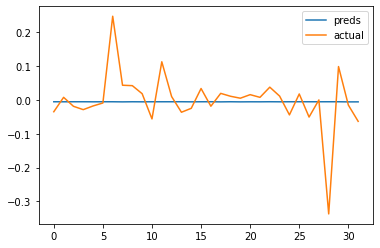

In [596]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

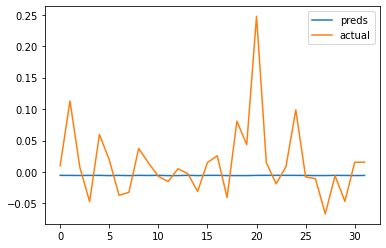

In [597]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

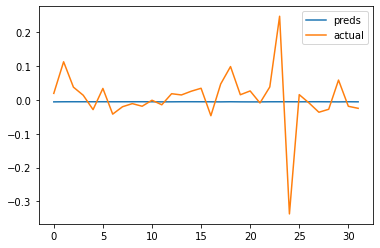

In [598]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)